# Improving ModSecurity WAF Using a Structured-Language Classifier


## For Computer Science B.Sc. Ariel University

By Maor Saadon, Shahar Zaidel, Eden Mor.

# Introdaction

In the ever-evolving landscape of cybersecurity, Web Application Firewalls (WAF) stand as critical defenders against malicious web requests. Traditionally, WAFs rely on predefined rule sets to identify and block potential threats. However, the complexity and sophistication of modern cyber attacks often outpace the capabilities of these rule-based systems, necessitating more dynamic and adaptive approaches. Machine learning (ML), particularly deep learning, has emerged as a promising solution, offering the potential to significantly enhance the detection and mitigation capabilities of WAFs through its ability to learn from data and identify complex patterns.

Our research explores the integration of machine learning techniques into the domain of web application security, focusing on the comparative analysis of various ML models in classifying web requests. We delve into models based on advanced text vectorization techniques, such as TF-IDF and Word2Vec, which transform web requests into numerical vectors that capture their semantic essence. These vectors are then utilized by machine learning algorithms, including the traditional k-Nearest Neighbors (kNN) algorithm, to distinguish between benign and malicious requests effectively.

Central to our investigation is the exploration of deep learning models in contrast to traditional ML models. Deep learning's capacity for learning hierarchical representations offers a nuanced approach to understanding and classifying web traffic. This leads us to our guiding research question: Does a machine learning model enhanced with deep learning techniques outperform traditional models in the context of Web Application Firewalls?

By examining the efficacy of deep learning models against their non-deep learning counterparts, our study aims to shed light on their relative performance and potential for improving the security mechanisms of WAFs. Through this comparative analysis, we aspire to contribute valuable insights into the advancement of cybersecurity methodologies, specifically in enhancing the resilience of web applications against the growing threat of cyber attacks.

## Install and import libraries

In [7]:
%pip install tensorflow
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import getopt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle as pkl
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import random

## Feature extraction functions

We will use the following feature extraction functions to extract features from the HTTP request:
1. calculate_alphanumeric_ratio
2. calculate_input_length
3. calculate_special_character_ratio


In [7]:
def calculate_alphanumeric_ratio(payload):
    alphanumeric_characters = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    alphanumeric_count = sum(1 for char in payload if char in alphanumeric_characters)
    payload_length = len(payload)
    input_length = max(payload_length, 1)  # Avoid division by zero if payload_length is 0
    alphanumeric_ratio = (alphanumeric_count / input_length) * 10
    return alphanumeric_ratio

def calculate_input_length(payload):
    input_length = len(payload)
    return input_length

def calculate_special_character_ratio(payload):
    alphanumeric_characters = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    special_count = sum(1 for char in payload if char not in alphanumeric_characters)
    payload_length = len(payload)
    input_length = max(payload_length, 1)  # Avoid division by zero if payload_length is 0
    special_ratio = (special_count / input_length) * 100
    return special_ratio


# Load and Procces the dataset 

The dataset is a CSV file with two columns: payload and label. The payload column contains the http request payload and the label column contains the label of the http request. The label is 1 if the request is malicious and 0 if the request is benign. 

In [8]:
# Load the dataset

# For CSIC 2010 dataset
df = pd.read_csv('CSIC.csv')
df = df.drop(['method', 'url', 'attack_feature'], axis=1)

# For HTTPParams dataset
# df = pd.read_csv('HTTPParams.csv')
# df = df.drop(['attack_feature'], axis=1)

# For QueriesDataset dataset
# df = pd.read_csv('QueriesDataset.csv')

# Shuffle the combined dataset to mix malicious and benign URLs
balanced_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print('Balanced Dataset Shape:', balanced_df.shape)
print('Balanced Dataset Distribution:', balanced_df['label'].value_counts())
print('Balanced Dataset Head (First 10 Rows):')
print(balanced_df.head(10))

Balanced Dataset Shape: (35602, 5)
Balanced Dataset Distribution: label
0    28150
1     7452
Name: count, dtype: int64
Balanced Dataset Head (First 10 Rows):
                                             payload  payload_len       alpha  \
0  modo=registro&login=bauer&password=P41DiD3M31t...          264  100.000000   
1  modo=insertar&precio=588&B1=Pasar+por+cajaparo...          152   66.355140   
2  modo=entrar&login=flaherty&pwd=j%2Baqu%E9s&rem...           65   89.285714   
3  id=%3F&nombre=Queso+Manchego&precio=85&cantida...           73   94.444444   
4                                                NaN            0    0.000000   
5                                                NaN            0    0.000000   
6                                  B2=Vaciar+carrito           17  100.000000   
7    id=%27%29%3Bwaitfor+delay+%270%3A0%3A15%27%3B--           47   64.285714   
8  modo=registro&login=schreife&password=EstOrnin...          257   98.675497   
9  id=3&nombre=Queso+Manchego&p

## Start testing with the options

We'll split the truncated dataset into a training set and a test set (80% training, 20% test) and use the training set to train the model and the test set to evaluate the model.

# CountVectorizer

In [9]:
# Fill NaN values with an empty string
def custom_tokenizer(text):
    return text.split('/')

# Fill NaN values with an empty string
balanced_df['payload'] = balanced_df['payload'].fillna("")

# Initialize the CountVectorizer with custom tokenizer

# If you want to use KNN or model, uncomment the following line
vectorizer = CountVectorizer(max_features=5000) # , max_df=0.85, tokenizer=custom_tokenizer, stop_words=['https', 'localhost:8080'])

# If you want to use TensorFlow or Ensemble model, uncomment the following line
# vectorizer = CountVectorizer(max_features=5000)

# Fit and transform the 'payload' column
X = vectorizer.fit_transform(balanced_df['payload'])

# Convert the result to an array if needed
X_array = X.toarray()

# Optionally, convert to DataFrame for better readability
feature_names = vectorizer.get_feature_names_out()
X_df = pd.DataFrame(X_array, columns=feature_names)

# Apply feature extraction
print('Feature extraction...')
features = balanced_df['payload'].apply(lambda x: pd.Series({
    'payload_len': calculate_input_length(str(x)),
    'alpha': calculate_alphanumeric_ratio(str(x)),
    'non_alpha': calculate_special_character_ratio(str(x)),
    }))


# Concatenate original DF with features
X_df = pd.concat([X_df, features], axis=1)
print('Balanced Dataset Shape:', X_df.shape)
print('Balanced Dataset:')
print(X_df)

# Define y
y = balanced_df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)


Feature extraction...
Balanced Dataset Shape: (35602, 5003)
Balanced Dataset:
       0040408141488994  0093197595343977  00947908d  01439  01722111d  \
0                     0                 0          0      0          0   
1                     0                 0          0      0          0   
2                     0                 0          0      0          0   
3                     0                 0          0      0          0   
4                     0                 0          0      0          0   
...                 ...               ...        ...    ...        ...   
35597                 0                 0          0      0          0   
35598                 0                 0          0      0          0   
35599                 0                 0          0      0          0   
35600                 0                 0          0      0          0   
35601                 0                 0          0      0          0   

       0197876956887475  02290  0

## K-Nearest Neighbors model

In [22]:
# Create an instance of kNN classifier
# the number of neighbors (k= 350) 
knn_model = KNeighborsClassifier(n_neighbors=350) 

# Train the kNN model
knn_model.fit(X_train, y_train)
print("K-Nearest Neighbors training is complete,\n predictions: ")

# Predict on the test set
predictions = knn_model.predict(X_test)

print('[+] \t Classification accuracy : ', "{:.2f}".format(metrics.accuracy_score(y_test, predictions) * 100), '%\n')
print('[+] \t Percentage of Anomaly requests in test set : ', "{:.2f}".format(y_test.mean() * 100), '%\n')
print('[+] \t Percentage of Normal requests in test set : ', "{:.2f}".format((1 - y_test.mean()) * 100), '%\n')

confusion = metrics.confusion_matrix(y_test, predictions)
TP = confusion[0, 0]
TN = confusion[1, 1]
FP = confusion[0, 1]
FN = confusion[1, 0]

print('[+] \t TP : ', TP, 'from ', (TP + TN + FP + FN))
print('    \t TN : ', TN, 'from ', (TP + TN + FP + FN))
print('    \t FP : ', FP, 'from ', (TP + TN + FP + FN))
print('    \t FN : ', FN, 'from ', (TP + TN + FP + FN))

print('\n[+] \t Metrics : ')
print('\t[-]  Accuracy Score (train_test_split): ', "{:.2f}".format(metrics.accuracy_score(y_test, predictions) * 100), '%')
print('\t[-]  Accuracy Score (k-fold): ',
      "{:.2f}".format(cross_val_score(knn_model, X_train, y_train, cv=100, scoring='accuracy').mean() * 100), '%')

print('\t[-]  Classification Error : ', "{:.2f}".format((1 - metrics.accuracy_score(y_test, predictions)) * 100), '%')
print('\t[-]  Recall : ', "{:.2f}".format(metrics.recall_score(y_test, predictions) * 100), '%')
specificity = TN / (TN + FP)
print('\t[-]  Specificity : ', "{:.2f}".format(specificity * 100), '%')
false_positive_rate = FP / float(TN + FP)
print('\t[-]  False Positive Rate : ', "{:.2f}".format(false_positive_rate * 100), '%')
precision = TP / float(TP + FP)
print('\t[-]  Precision : ', "{:.2f}".format(precision * 100), '%')


K-Nearest Neighbors training is complete,
 predictions: 
[+] 	 Classification accuracy :  98.44 %

[+] 	 Percentage of Anomaly requests in test set :  38.38 %

[+] 	 Percentage of Normal requests in test set :  61.62 %

[+] 	 TP :  3793 from  6214
    	 TN :  2324 from  6214
    	 FP :  36 from  6214
    	 FN :  61 from  6214

[+] 	 Metrics : 
	[-]  Accuracy Score (train_test_split):  98.44 %
	[-]  Accuracy Score (k-fold):  97.93 %
	[-]  Classification Error :  1.56 %
	[-]  Recall :  97.44 %
	[-]  Specificity :  98.47 %
	[-]  False Positive Rate :  1.53 %
	[-]  Precision :  99.06 %


## TensorFlow neural network, with feature extraction

A deep learning model using a Dense Neural Network (DNN), also known as a Fully Connected Network. This type of neural network architecture is characterized by its layers of neurons where each neuron in one layer is connected to all neurons in the next layer.

In [23]:
n_features = X_train.shape[1]
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])
# fit the model

# use asarray to convert the dataframe to array
X_train_1 = np.asarray(X_train)
y_train_1 = np.asarray(y_train)

model.fit(X_train_1, y_train_1, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

X_test_1 = np.asarray(X_test)
y_test_1 = np.asarray(y_test)

# evaluate the model
loss, accuracy, recall, precision = model.evaluate(X_test_1, y_test_1, verbose=0)
print('Test Accuracy: %.4f' % accuracy)
print('Recall: %.4f' % recall)
print('Precision: %.4f' % precision)

y_pred_classes = (model.predict(X_test_1) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test_1, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

Epoch 1/10
622/622 [==============================] - 3s 3ms/step - loss: 0.1202 - accuracy: 0.9588 - recall: 0.8914 - precision: 0.9996 - val_loss: 0.0158 - val_accuracy: 0.9958 - val_recall: 0.9897 - val_precision: 0.9989
Epoch 2/10
622/622 [==============================] - 1s 2ms/step - loss: 0.0088 - accuracy: 0.9980 - recall: 0.9955 - precision: 0.9992 - val_loss: 0.0095 - val_accuracy: 0.9968 - val_recall: 0.9924 - val_precision: 0.9989
Epoch 3/10
622/622 [==============================] - 1s 2ms/step - loss: 0.0094 - accuracy: 0.9980 - recall: 0.9968 - precision: 0.9980 - val_loss: 0.0098 - val_accuracy: 0.9968 - val_recall: 0.9946 - val_precision: 0.9968
Epoch 4/10
622/622 [==============================] - 1s 2ms/step - loss: 0.0048 - accuracy: 0.9990 - recall: 0.9980 - precision: 0.9993 - val_loss: 0.0073 - val_accuracy: 0.9972 - val_recall: 0.9935 - val_precision: 0.9989
Epoch 5/10
622/622 [==============================] - 1s 2ms/step - loss: 0.0040 - accuracy: 0.9991 - re

In [10]:
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

# Initialize individual models
log_clf = LogisticRegression(random_state=42, max_iter=1000)
dt_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
svm_clf = GaussianNB() # Enable probability for soft voting
#svm_clf = ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=42)

# Consider including your previously defined kNN model
# knn_model = KNeighborsClassifier(n_neighbors=350)

# load my model from .pkl file
# with open('knn_model_counter.pkl', 'rb') as f:
#      knn_model = pkl.load(f)


# Create ensemble model using soft voting
ensemble_clf = VotingClassifier(estimators=[
    ('lr', log_clf),
    ('dt', dt_clf),
    ('svc', dt_clf),
    # ('knn', knn_model)  # Add your kNN model
    ], voting='soft')

ensemble_clf.fit(X_train, y_train)

# Predict on the test set
ensemble_predictions = ensemble_clf.predict(X_test)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_CMatrix = confusion_matrix(y_test, ensemble_predictions)

ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions)
recall_score = metrics.recall_score(y_test, ensemble_predictions)
ensemble_CMatrix = confusion_matrix(y_test, ensemble_predictions)

# Print evaluation metrics
print("Ensemble Model Precision:", ensemble_precision)
print("Ensemble Model Recall:", recall_score)
print("Ensemble Model Accuracy:", ensemble_accuracy)

# Print evaluation metrics
print("Ensemble Model Accuracy:", ensemble_accuracy)
print("Ensemble Model Confusion Matrix:", ensemble_CMatrix)
print("Ensemble Classification Report:\n", classification_report(y_test, ensemble_predictions))


C:\Users\shaha\PycharmProjects\CMD_final_project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble Model Precision: 0.9985007496251874
Ensemble Model Recall: 0.8927613941018767
Ensemble Model Accuracy: 0.977250386181716
Ensemble Model Accuracy: 0.977250386181716
Ensemble Model Confusion Matrix: [[5627    2]
 [ 160 1332]]
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      5629
           1       1.00      0.89      0.94      1492

    accuracy                           0.98      7121
   macro avg       0.99      0.95      0.96      7121
weighted avg       0.98      0.98      0.98      7121



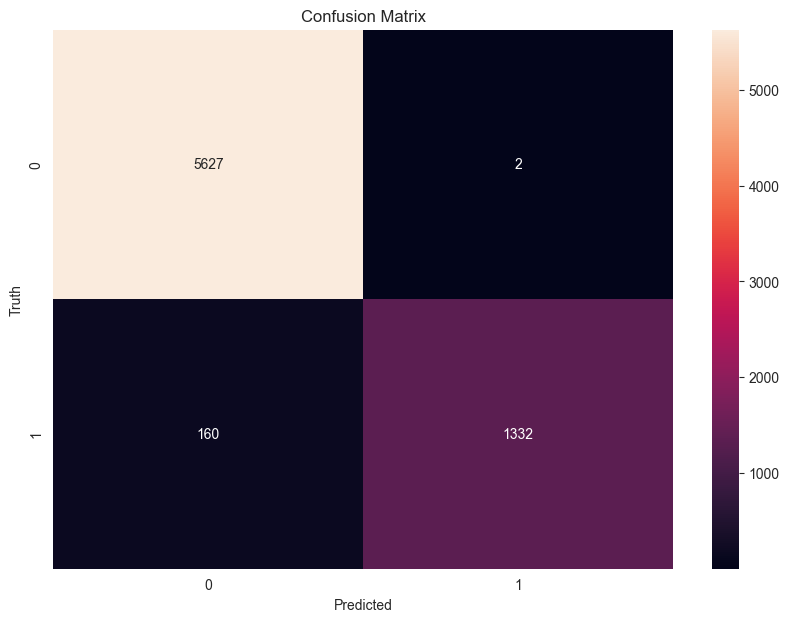

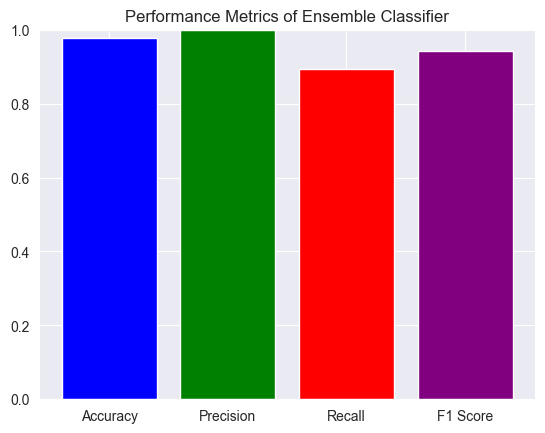

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already trained your ensemble_clf and made predictions

# Confusion Matrix
cm = confusion_matrix(y_test, ensemble_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Performance Metrics
accuracy = accuracy_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions)
recall = recall_score(y_test, ensemble_predictions)
f1 = f1_score(y_test, ensemble_predictions)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Performance Metrics of Ensemble Classifier')
plt.ylim(0, 1)  # Assuming your metrics are between 0 and 1
plt.show()